# Introduction

This notebook presents a simple Generative Adversarial Network (GAN) and more advanced Deep Convolutional GAN. Both are applied MNIST dataset.

We will create three sub-graphs for GAN network as follows:

* **Generator**: *noise -> MNIST images*, contains set of **Generator Weights**, weights are trained in Gan Model, so it doesn't need it's own optimizer
* **Discriminator**: *MNIST images -> fake/real*, contains set of **Discriminator Weights**, trained like usual Keras model
* **Gan Model**: noise -> fake/real, all weights are shared from generator/discriminator above, discriminator weights are set as non-trainable

**Contents**

* [MNIST Dataset](#MNIST-Dataset)
* [Keras GAN](#Keras-GAN)
* [Keras DCGAN](#Keras-DCGAN)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

In [3]:
#import os
#from tqdm import tqdm

In [4]:
#from tensorflow.keras.layers import Imput, 

# MNIST Dataset

Load MNIST Dataset from Keras API. We only need train images, ignore labels and validation set.

In [5]:
(x_train_raw, _), (_, _) = tf.keras.datasets.mnist.load_data()

Convert to -1..1 range to mach tanh output from generator

In [6]:
x_train = (x_train_raw-127.5) / 127.5
x_train = x_train.reshape([len(x_train), -1])
print('x_train.shape:', x_train.shape)
print('x_train.min():', x_train.min())
print('x_train.max():', x_train.max())
print('x_train:\n', x_train)

x_train.shape: (60000, 784)
x_train.min(): -1.0
x_train.max(): 1.0
x_train:
 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


# Keras GAN

**Generator**

* converts *noise* input into *MNIST-like* image
* there is no name to compile model, we never optimize generator directly
* I don't think this is an efficient implementation (although very common on the internet) - alternative would be to feed noise directly to gan_model and remove *generator.predict()* call in the train loop.

In [7]:
from tensorflow.keras.layers import InputLayer, Dense  # InputLayer for pretier names in TensorBoard

generator = tf.keras.Sequential(name='Generator')
generator.add(InputLayer(input_shape=(100,), name='GenInput'))
generator.add(Dense(units=128, activation='elu', name='GenHidden'))
generator.add(Dense(784, activation='tanh', name='GenOutput'))
# generator.compile(...)                                            # no need
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GenHidden (Dense)            (None, 128)               12928     
_________________________________________________________________
GenOutput (Dense)            (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


<img src="assets/gan_mlp_generator.png"/>

Optional: see graph created so far in TensorBoard

In [8]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=tf.get_default_graph())
# writer.flush()

**Discriminator**

* input is *MNIST-like* image, output is *fake/true label*

In [9]:
discriminator = tf.keras.Sequential(name='Discriminator')
discriminator.add(InputLayer(input_shape=(784,), name='DiscInput'))
discriminator.add(Dense(units=128, activation='elu', input_dim=784, name='DiscHidden'))
discriminator.add(Dense(units=1, activation='sigmoid', name='DiscOut'))
#discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DiscHidden (Dense)           (None, 128)               100480    
_________________________________________________________________
DiscOut (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


<img src="assets/gan_mlp_discriminator.png"/>

Optional: see graph created so far in TensorBoard - this should produce two independent sub-graphs, one for generator and one for discriminator

In [10]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=tf.get_default_graph())
# writer.flush()

**GAN Model**

* we need to set discriminator part as non-trainable before calling compile() - this doesn't affect previously created discriminator
* changing discriminator trainable flag after compile() call has no effect on weights being trainable or not
* note that even though this creates new sub-graph, all weights are shared from generator and discriminator above

In [11]:
discriminator.trainable = False                                  # must make non-trainable before compiling gan_model
gan_model = tf.keras.Sequential(name='GAN')                      # (this doesn't affect anything we done earlier)a
gan_model.add(InputLayer(input_shape=(100,), name='GANInput'))
gan_model.add(generator)
gan_model.add(discriminator)
#gan_model.compile(optimizer='adam', loss='binary_crossentropy')
gan_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='binary_crossentropy')
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


<img src="assets/gan_mlp_gan_model.png"/>

Optional: see graph created so far in TensorBoard - because weights are shared this will create somewhat messy rendering of three sub-graphs

**Train GAN**

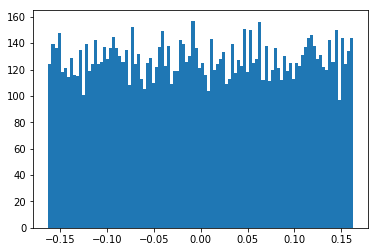

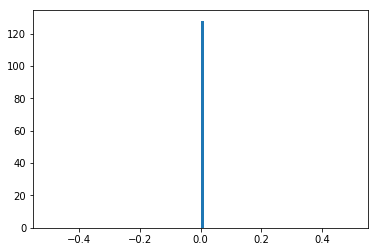

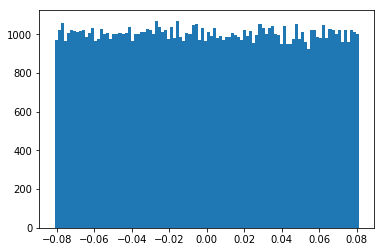

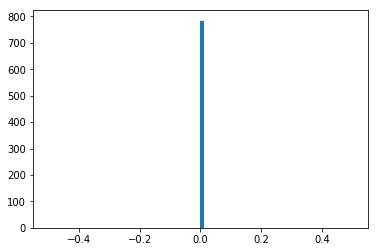

In [12]:
plt.hist(generator.get_weights()[0].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[1].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[2].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[3].ravel(), bins=100);  plt.show();

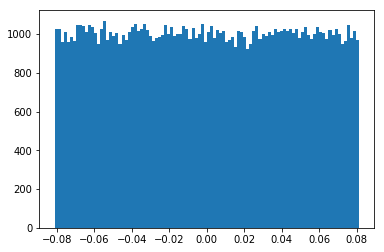

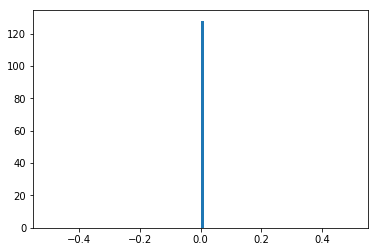

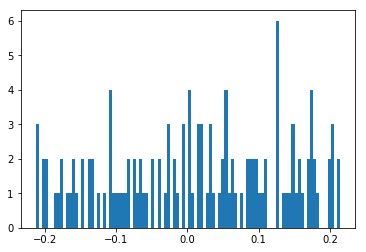

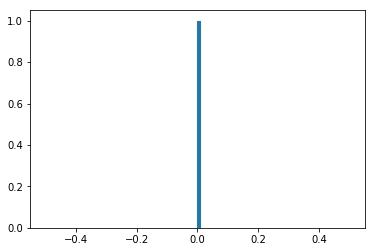

In [13]:
plt.hist(discriminator.get_weights()[0].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[1].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[2].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[3].ravel(), bins=100);  plt.show();

In [14]:
n_batch = 100
n_epochs = 20

In [15]:
losses = {'gen':[], 'disc':[]}
indices = np.array(range(len(x_train)))

for e in range(n_epochs):
    np.random.shuffle(indices)
    for i in range(0, len(x_train), n_batch):

        #noise = np.random.normal(size=[n_batch, 100])              # shape (n_batch, n_rand)
        noise = np.random.uniform(-1, 1, size=[n_batch, 100])
        x_fake = generator.predict(noise, batch_size=n_batch)       # shape (n_batch, n_data)

        
        #show_images(x_fake[10:20])
        #break
        
        i_batch = indices[i:i+n_batch]
        x_real = x_train[i_batch]

        x_all = np.concatenate([x_real, x_fake])
        y_all = np.concatenate([.9 * np.ones([n_batch,1]),
                                np.zeros([n_batch,1])])

        Wg = generator.get_weights()[0]
        Wd = discriminator.get_weights()[0]
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(x_all, y_all)
        discriminator.trainable = False
        assert np.alltrue(Wg == generator.get_weights()[0])
        assert np.any(Wd != discriminator.get_weights()[0])


        Wg = generator.get_weights()[0]
        Wd = discriminator.get_weights()[0]
        #noise = np.random.normal(size=[n_batch, 100])
        #noise = np.random.uniform(-1, 1, size=[n_batch, 100])
        y_fake = np.ones([n_batch, 1])
        gloss = gan_model.train_on_batch(noise, y_fake)
        assert np.any(Wg != generator.get_weights()[0])
        assert np.alltrue(Wd == discriminator.get_weights()[0])

        losses['disc'].append(dloss)
        losses['gen'].append(gloss)

    print(f'epoch: {e:3}     gloss: {gloss:4.2f}     dloss: {dloss:4.2f}')


epoch:   0     gloss: 3.41     dloss: 0.27
epoch:   1     gloss: 6.11     dloss: 0.26
epoch:   2     gloss: 3.09     dloss: 0.49
epoch:   3     gloss: 3.31     dloss: 0.33
epoch:   4     gloss: 2.12     dloss: 0.43
epoch:   5     gloss: 3.90     dloss: 0.50
epoch:   6     gloss: 2.73     dloss: 0.55
epoch:   7     gloss: 2.52     dloss: 0.36
epoch:   8     gloss: 3.30     dloss: 0.38
epoch:   9     gloss: 2.76     dloss: 0.55
epoch:  10     gloss: 2.83     dloss: 0.42
epoch:  11     gloss: 2.74     dloss: 0.61
epoch:  12     gloss: 2.36     dloss: 0.55
epoch:  13     gloss: 2.31     dloss: 0.55
epoch:  14     gloss: 2.83     dloss: 0.53
epoch:  15     gloss: 1.98     dloss: 0.61
epoch:  16     gloss: 1.75     dloss: 0.50
epoch:  17     gloss: 1.85     dloss: 0.62
epoch:  18     gloss: 1.85     dloss: 0.66
epoch:  19     gloss: 1.84     dloss: 0.51


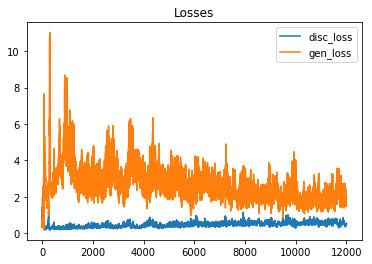

In [16]:
plt.plot(losses['disc'], label='disc_loss')
plt.plot(losses['gen'], label='gen_loss')
plt.title('Losses')
plt.legend();

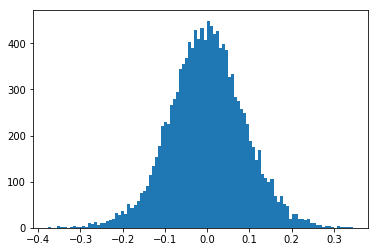

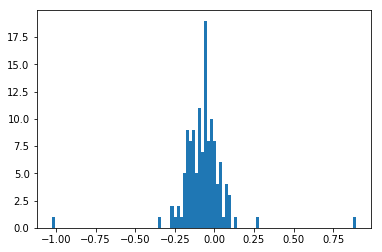

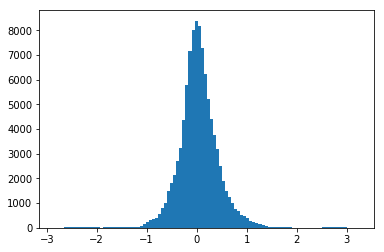

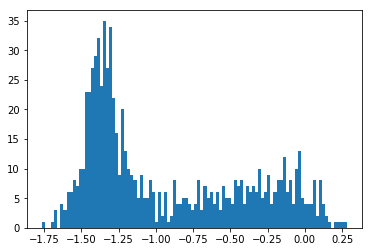

In [17]:
plt.hist(generator.get_weights()[0].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[1].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[2].ravel(), bins=100);  plt.show();
plt.hist(generator.get_weights()[3].ravel(), bins=100);  plt.show();

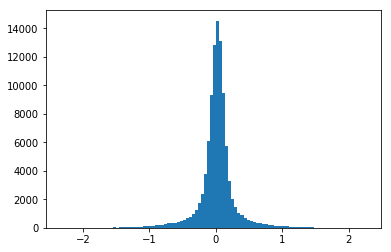

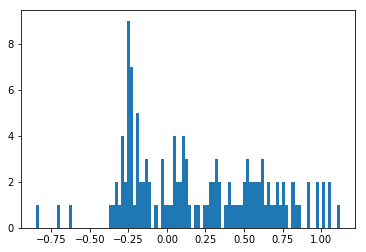

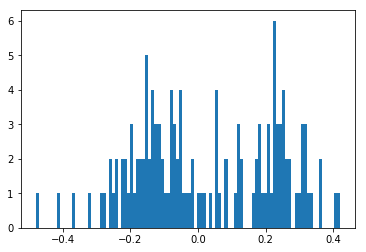

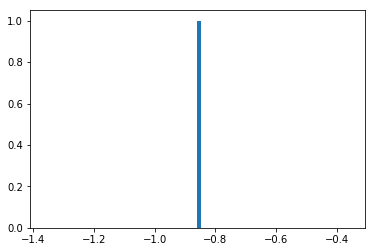

In [18]:
plt.hist(discriminator.get_weights()[0].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[1].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[2].ravel(), bins=100);  plt.show();
plt.hist(discriminator.get_weights()[3].ravel(), bins=100);  plt.show();

In [19]:
print(i)

59900


In [20]:
generator.weights

[<tf.Variable 'GenHidden/kernel:0' shape=(100, 128) dtype=float32>,
 <tf.Variable 'GenHidden/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'GenOutput/kernel:0' shape=(128, 784) dtype=float32>,
 <tf.Variable 'GenOutput/bias:0' shape=(784,) dtype=float32>]

In [21]:
aa = generator.get_weights()[0]
bb = gan_model.get_weights()[0]
assert np.alltrue(aa ==  bb)

In [22]:
aa = discriminator.get_weights()[3]
bb = gan_model.get_weights()[3+4]
assert np.alltrue(aa ==  bb)

Plot losses

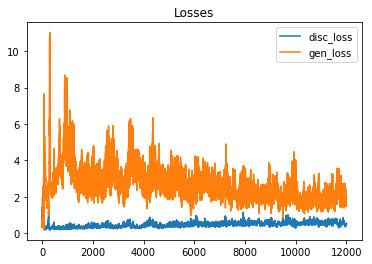

In [23]:
plt.plot(losses['disc'], label='disc_loss')
plt.plot(losses['gen'], label='gen_loss')
plt.title('Losses')
plt.legend();

Helper to show bunch of MNIST-like images

In [24]:
def show_images(x):
    fig, axes = plt.subplots(nrows=1, ncols=len(x), figsize=[20,4])
    for i, ax in enumerate(axes):
        ax.imshow(x[i].reshape([28,28]), cmap='gray', vmin=-1, vmax=1)
        ax.axis('off')

Show some real images

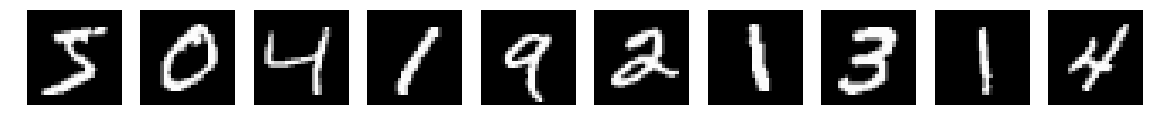

In [25]:
real_imgs = x_train[0:10]
show_images(real_imgs)

Show some fakes

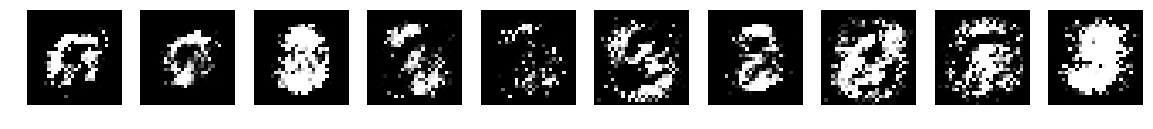

In [26]:
noise = np.random.normal(size=[10, 100])
fake_imgs = generator.predict(x=noise, batch_size=10)
show_images(fake_imgs)

**Generate Graphs**

This was used to generate graphs in this post

In [27]:
# tf.keras.utils.plot_model(generator, to_file='assets/gan_mlp_generator.png', show_shapes=True)
# tf.keras.utils.plot_model(discriminator, to_file='assets/gan_mlp_discriminator.png', show_shapes=True)
# tf.keras.utils.plot_model(model, to_file='assets/gan_mlp_gan_model.png', show_shapes=True)